<a href="https://colab.research.google.com/github/Aayushktyagi/Pytorch_resources/blob/master/Efficientnet_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Stanford Dog classification 

*   Loading dataset 
  1.   wget images
  2.   unzip
  3.   resize to 256x256


*   Dataset Visualization
*   Initialize EfficientNet
*   Train EfficientNet
*   Evaluate model 
*   Visualize predictions 







In [ ]:
import os
from os import path

In [ ]:
# load dataset
if os.path.exists("images.tar") and os.path.exists("annotation.tar"):
  # unzip images and annotations 
  print("file exist: Unzipping ....")
  !tar -xvf images.tar
  !tar -xvf annotation.tar
else:
  !wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar
  !wget http://vision.stanford.edu/aditya86/ImageNetDogs/annotation.tar
  # unzip images and annotations 
  !tar -xvf images.tar
  !tar -xvf annotation.tar

In [ ]:
import torch 
import numpy as np
from torchvision import models, datasets , transforms
from torch.utils.data.dataset import Dataset
from torch.utils.data import Subset
import torchvision
import torch.optim as optim
import matplotlib.pyplot as plt
import time 
import torch.nn as nn 

In [ ]:
# pre-process datasest

folder_name = 'Images'

data_transforms = {
    'Train': transforms.Compose([
    transforms.Resize((256,256)),
    transforms.RandomRotation(10),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 406],[0.229, 0.224, 0.225])
    ]),
    'Test': transforms.Compose([
    transforms.Resize((256,256)),
    transforms.ToTensor(),
    # transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])
    ])
}

class CustomDataSet(Dataset):
  def __init__(self, dataset, transform = None):
    self.dataset = dataset
    self.transform = transform

  def __getitem__(self, index):
    if self.transform:
      x = self.transform(self.dataset[index][0])
    else:
      x = self.dataset[index][0]
    y = self.dataset[index][1]
    return x,y

  def __len__(self):
    return len(self.dataset)

#get data instance
imagedatafolder = datasets.ImageFolder(folder_name)
traindataset = CustomDataSet(imagedatafolder , data_transforms['Train'])
validdataset = CustomDataSet(imagedatafolder , data_transforms['Test'])
testdataset = CustomDataSet(imagedatafolder, data_transforms['Test'])

# train valid test split

train_size = 0.8
data_shuffle = True
random_seed = 42
batch_size = 4
num_worker = 0

dataset_size = len(imagedatafolder)
indices = list(range(dataset_size))

split = int(np.floor(train_size * dataset_size))
split2 = int(np.floor( (train_size + (1-train_size) / 2)* dataset_size))

if data_shuffle:
  np.random.seed(random_seed)
  np.random.shuffle(indices)

train_idx , valid_idx , test_idx = indices[:split] , indices[split:split2] , indices[split2:]

trainsplit = Subset(traindataset , train_idx)
validsplit = Subset(validdataset , valid_idx)
testsplit = Subset(testdataset , test_idx)

trainloader = torch.utils.data.DataLoader(trainsplit , batch_size = batch_size,
                                          num_workers = num_worker , drop_last = True)
validloader = torch.utils.data.DataLoader(validsplit, batch_size = batch_size,
                                          num_workers = num_worker , drop_last= True)
testloader = torch.utils.data.DataLoader(testsplit, batch_size = batch_size,
                                         num_workers = num_worker, drop_last= True)

# check size of train, valid, test

print("Train:{} , Valid:{} , Test:{}".format(len(trainloader),len(validloader),len(testloader)))

use_gpu = torch.cuda.is_available()

Train:4116 , Valid:514 , Test:514


In [ ]:
classes  = imagedatafolder.classes
classes_name = []
# split name from "-" 
for i  in classes:
  name = i.split("-")
  classes_name.append(name[1]) 

print(classes_name , len(classes_name))

['Chihuahua', 'Japanese_spaniel', 'Maltese_dog', 'Pekinese', 'Shih', 'Blenheim_spaniel', 'papillon', 'toy_terrier', 'Rhodesian_ridgeback', 'Afghan_hound', 'basset', 'beagle', 'bloodhound', 'bluetick', 'black', 'Walker_hound', 'English_foxhound', 'redbone', 'borzoi', 'Irish_wolfhound', 'Italian_greyhound', 'whippet', 'Ibizan_hound', 'Norwegian_elkhound', 'otterhound', 'Saluki', 'Scottish_deerhound', 'Weimaraner', 'Staffordshire_bullterrier', 'American_Staffordshire_terrier', 'Bedlington_terrier', 'Border_terrier', 'Kerry_blue_terrier', 'Irish_terrier', 'Norfolk_terrier', 'Norwich_terrier', 'Yorkshire_terrier', 'wire', 'Lakeland_terrier', 'Sealyham_terrier', 'Airedale', 'cairn', 'Australian_terrier', 'Dandie_Dinmont', 'Boston_bull', 'miniature_schnauzer', 'giant_schnauzer', 'standard_schnauzer', 'Scotch_terrier', 'Tibetan_terrier', 'silky_terrier', 'soft', 'West_Highland_white_terrier', 'Lhasa', 'flat', 'curly', 'golden_retriever', 'Labrador_retriever', 'Chesapeake_Bay_retriever', 'Germa

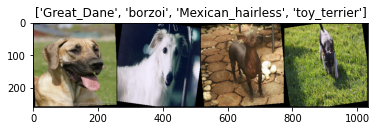

In [ ]:
# Data visualization 
# Class histogram 

def imshow(img , title = None):
  img = img.numpy().transpose((1,2,0))
  # mean = np.array([0.485 , 0.456, 0.406])
  # std = np.array([0.229,0.224,0.225])
  # img = std * img + mean
  img = np.clip(img , 0,1)
  plt.imshow(img)
  if title is not None:
    plt.title(title)
  plt.pause(0.001)


images , labels = next(iter(trainloader))

#make grid
out = torchvision.utils.make_grid(images)

#show image 
imshow(out , title = [classes_name[x] for x in labels])


In [ ]:
!pip install efficientnet_pytorch

In [ ]:
# define efficientnet model 
from efficientnet_pytorch import EfficientNet

model = EfficientNet.from_name('efficientnet-b1')

#unfreez model 
for param in model.parameters():
  param.requires_grad = True

# define linear layur to map num of classes 
num_input_features = model._fc.in_features 
model._fc = nn.Linear(num_input_features , len(classes_name))

if use_gpu:
  model = model.cuda()

#define loss
criterion = nn.CrossEntropyLoss()

# define optimizer 
optimzer = optim.SGD(model.parameters(), lr = 0.01 , momentum = 0.09)



In [ ]:
def train_model(model, criterion , optimizer , num_epochs = 25 , save_model = False):
  start_time = time.time()

  best_model_wts = model.state_dict()
  best_acc = 0.0

  for epochs in range(num_epochs):
    print("{}/{}".format(epochs , num_epochs - 1))
    print('-' * 10)

    for phase in ['Training' , 'Validation']:
      if phase == 'Training':
        model = model.train()
      else:
        model = model.eval()
      
      running_loss = 0.0
      running_correct = 0

      if phase == 'Training':
        for images , labels in trainloader:
          images = images.to_device()
          labels = labels.to_device()

          #zero the parameter gradient
          optimizer.zero_grad()

          #forward
          out = model(images)
          _ , preds = torch.max(out , 1)
          loss = criterion(out , labels)

          loss.backward()
          optimizer.step()

          #stats 
          running_loss += loss.data[0]
          running_correct += torch.sum(preds == labels.data)

        epoch_loss = running_loss / len(trainloader) * batch_size
        epochs_acc = running_correct / len(trainloader) * batch_size

        print("{} : Loss : {} : Acc : P{}".format(phase , epochs_loss , epochs_acc))
      
      if phase = 'Validation':
        for images , labels in validloader:
          images = images.to_device()
          labels = labels.to_device()

          #zero the parameter gradient
          optimizer.zero_grad()

          # forward
          out = model(images)
          _ , preds = torch.max(out,1)
          loss = criterion(out, labels)

           #stats
          running_loss += loss.data[0]
          running_acc += torch.sum(preds == labels.data)

        epochs_loss = running_loss / (len(validloader) * batch_size)
        epochs_acc = running_acc / (len(validloader) * batch_size)

        print("{} : Loss:{} : Acc : {}".format(phase , epochs_loss , epochs_acc))

        if epochs_acc > best_acc:
          bast_acc = epochs_acc
          best_model_wts = model.state_dict()
          if save_model:
            state = {'model':model.state_dict() , 'optim':optimizer.state_dict()}
            torch.save(state , 'efficientnet_dogbreed.pth')

  time_escaped = time.time() - start_time
  print("Training completed in :{:.0f}m {:.0f}s".format(time_escaped // 60 , time_escaped % 60)) 

  print("Best val accuracy:{}".format(best_acc))

  #return best model 
  model.load_state_dict(best_model_wts)

  return model



In [ ]:
model_t = train_model(model , criterion , optimizer)